# ***Detecting presence of Heart Disease using classification***
#### Group Members: Ishan Kumar Singh, Tony Kashimori, Jeffrey Kim

### Introduction

Heart diseases, a global health concern, predominantly affect the elderly. With countless victims each year, early detection remains crucial. 

Our project investigates the likelihood of heart disease using key indicators: age, sex, resting blood pressure, cholesterol, and maximum heart rate.

The primary question is: **"Can age, sex, resting blood pressure, cholesterol, and maximum heart rate predict heart disease?"** 

The data set combines five heart datasets, offering the most extensive collection on heart disease prediction with 918 unique observations, focusing on key indicators to assess heart disease risk. Shedding light on these factors' roles, enhances our understanding of future preventive medical approaches.

<img src="https://img.freepik.com/premium-vector/prevention-treatment-heart-disease-cartoon-body-organ-mascot-cute-character-with-medical-dropper-cardiovascular-health-protection-recovery-vector-preventive-medicine-concept_176411-4148.jpg?w=2000" alt="Alternative text" width="200" height="200" />

https://img.freepik.com/premium-vector/prevention-treatment-heart-disease-cartoon-body-organ-mascot-cute-character-with-medical-dropper-cardiovascular-health-protection-recovery-vector-preventive-medicine-concept_176411-4148.jpg?w=740

## Methods

Importing all the libraries that will be used in our data analysis and modeling.

In [43]:
### Run this cell before continuing. 
library(tidyverse)
library(repr)
library(tidymodels)
options(repr.matrix.max.rows = 6)
library(dplyr)

Install the `kknn` package into our server. This will be used in building the model based on knn classification.

In [44]:
install.packages("kknn")

Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done



Read in the `heart.csv` data using `read_csv()` and assign it to an object called `data`. The data is accessed using the url `https://raw.githubusercontent.com/jeffreyykim/DSCI-project-009-40-Group_Contract/94fda1d002bf5ab24d2be98a7c63061a1dad7ab0/heart.csv`.

In [45]:
data <- read_csv("https://raw.githubusercontent.com/jeffreyykim/DSCI-project-009-40-Group_Contract/94fda1d002bf5ab24d2be98a7c63061a1dad7ab0/heart.csv")

Rows: 918 Columns: 12
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (5): Sex, ChestPainType, RestingECG, ExerciseAngina, ST_Slope
dbl (7): Age, RestingBP, Cholesterol, FastingBS, MaxHR, Oldpeak, HeartDisease

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


From our data set we remove all the values that include `NA` using the function `drop_na()`

In [46]:
data <- data |> drop_na()
data

Age Sex ChestPainType RestingBP Cholesterol FastingBS RestingECG MaxHR
1   40  M   ATA           140       289         0         Normal     172  
2   49  F   NAP           160       180         0         Normal     156  
3   37  M   ATA           130       283         0         ST          98  
⋮   ⋮   ⋮   ⋮             ⋮         ⋮           ⋮         ⋮          ⋮    
916 57  M   ASY           130       131         0         Normal     115  
917 57  F   ATA           130       236         0         LVH        174  
918 38  M   NAP           138       175         0         Normal     173  
    ExerciseAngina Oldpeak ST_Slope HeartDisease
1   N              0       Up       0           
2   N              1       Flat     1           
3   N              0       Up       0           
⋮   ⋮              ⋮       ⋮        ⋮           
916 Y              1.2     Flat     1           
917 N              0.0     Flat     1           
918 N              0.0     Up       0

We now begin by wrangling our data. Firstly, we convert our classifier column as a factor and change the responses to `Positive` *(1 in data set)* and `Negative` *(0 in data set)* in accordance with the key as mentioned at the source. We do this to make our predictions more informative and easier to comprehend.

In [47]:
# cleaning and wrangling the data, renaming the values in a column
set.seed(1)
data <- data |>
        mutate(HeartDisease = as_factor(HeartDisease)) |>
        mutate(HeartDisease = fct_recode(HeartDisease, "Positive" = "1", "Negative" = "0"))

We now move on to selecting only the valid columns based on our intuition and the data analysis performed below. According to the plots and the summary table shown below, these predictors tend to be influenced by the patients with heart disease.  

We also remove the values from the selected columns that don't make sense in our analysis. For example, it is impossible for a living person to have their maximum heart rate, resting blood pressure and cholesterol levels to be 0.

we also decide to change the categorical variable Sex into quantitative variable by depicting the values as 1, and 0. This allows us to us this a predictor in our analysis by a `knn` model. We change the column name into `Male` which had value 1 for *Male* and 0 for *Female*. Since Sex of the patient may also play a huge role in determining whether they do or do not have a heart disease as implied by the figure below  , therefore we wanted to include it into our analysis. 

In [48]:
# selecting only the relevant columns
selected_data <- select(data, HeartDisease, Cholesterol,  Age, RestingBP, MaxHR, Sex) |>
                 filter(Cholesterol != 0, MaxHR !=0, RestingBP != 0) |>
                mutate(Male=as.integer(Sex == "M")) |>
                select(-Sex)
                 # mutate(Sex = as.factor(Sex)) |> mutate(Sex = fct_recode(Sex, "1" = "M", "0" = "F"))
selected_data

HeartDisease Cholesterol Age RestingBP MaxHR Male
1   Negative     289         40  140       172   1   
2   Positive     180         49  160       156   0   
3   Negative     283         37  130        98   1   
⋮   ⋮            ⋮           ⋮   ⋮         ⋮     ⋮   
744 Positive     131         57  130       115   1   
745 Positive     236         57  130       174   0   
746 Negative     175         38  138       173   1

**Variables used:**
- `HeartDisease` (Positive / Negative) : Patient with or without Heart Disease.
- `Cholesterol` (mm/dl): Cholesterol levels measured in the given unit.
- `Age` (years) : Age of Patient.
- `RestingBP` (mm Hg) : Resting Blood Pressure measured in the given unit.
- `MaxHR` (BPM) : Maximum Heart Rate measured in the given unit.
- `Male` (1: Male / 0: Female) : Sex of Patient


**Procedure**
1) Importing the libraries and data from `Kaggle` into R.
2) Cleaning, wrangling and renaming of data into R. Selecting only columns based on preliminary analysis of data.
3) Splitting into `training` and `testing` data. Scaling the data while making recipes.
4) Find best value of k to be used by `cross validation` of training data.
5) Using this k value to build our model and testing it onto the testing set.
6) Measuring the accuracy and analyzing the confusion matrix.

We split the `selected_data` into training and testing data set according to the proportions `0.75` and `0.25` using `initial_split`. We make sure that the proportion of positive and negative tested patients remain the same in both the data frames using `strata`. 

In [49]:
# spliting data into testing and training sets
data_split <- initial_split(selected_data, prop = 0.75, strata = HeartDisease)
training_data <- training(data_split)
testing_data <- testing(data_split)
training_data
testing_data

HeartDisease Cholesterol Age RestingBP MaxHR Male
1   Negative     289         40  140       172   1   
2   Negative     283         37  130        98   1   
3   Negative     204         39  120       145   1   
⋮   ⋮            ⋮           ⋮   ⋮         ⋮     ⋮   
557 Positive     193         68  144       141   1   
558 Positive     131         57  130       115   1   
559 Positive     236         57  130       174   0

HeartDisease Cholesterol Age RestingBP MaxHR Male
1   Negative     195         54  150       122   1   
2   Negative     339         39  120       170   1   
3   Negative     237         45  130       170   0   
⋮   ⋮            ⋮           ⋮   ⋮         ⋮     ⋮   
185 Negative     253         47  130       179   1   
186 Positive     203         61  148       161   1   
187 Negative     175         38  138       173   1

### Preliminary exploratory data analysis

#### Building a bar plot to highlight the proportion of Sex of patients with `HeartDisease`.

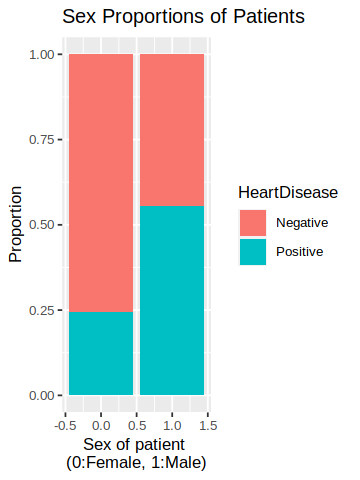

In [50]:
options(repr.plot.width = 3, repr.plot.height = 4)
sex_prop <- ggplot(training_data, aes(x = Male, fill = HeartDisease)) + geom_bar(position = "fill") +
         labs(x = "Sex of patient \n(0:Female, 1:Male)", y = "Proportion", colour = "Heart Disease") + ggtitle("Sex Proportions of Patients") +
         theme(text = element_text(size=10))
sex_prop

***figure 1***

From the figure we observe that the proportion of females that have heart disease is only 0.25 as compared to 0.5 in males. Thus, more males tend to be positive for heart diseases.

#### Building a histogram to highlight the distribution of `Cholesterol` levels with `HeartDisease`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


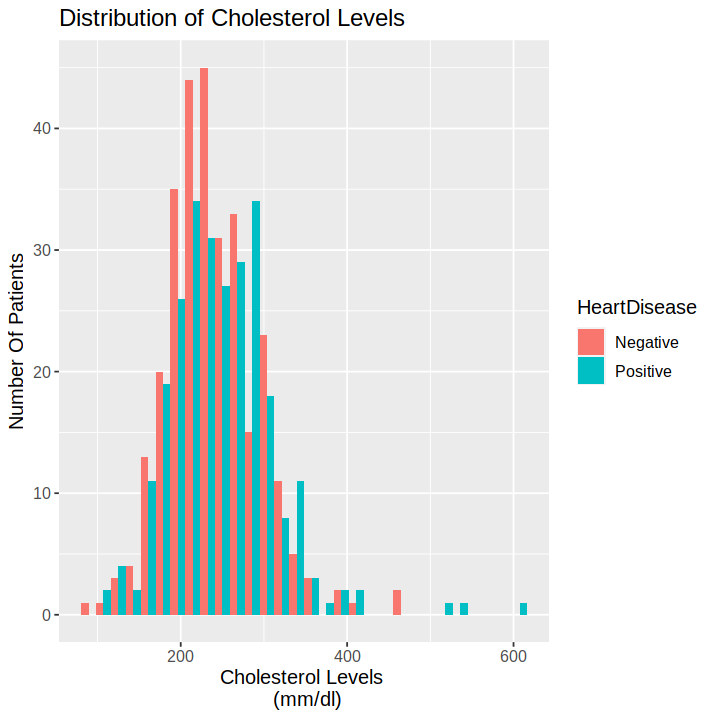

In [51]:
options(repr.plot.width = 6, repr.plot.height = 6)
cholesterol_dist <- ggplot(training_data, aes(x = Cholesterol, fill = HeartDisease)) + geom_histogram(position = "dodge") + 
         labs(x = "Cholesterol Levels \n (mm/dl)", y = "Number Of Patients", colour = "Heart Disease") + ggtitle("Distribution of Cholesterol Levels") +
         theme(text = element_text(size=12)) 
cholesterol_dist

***figure 2***

This distribution does not provide a very clear insight or trend regarding cholesterol levels and heart disease. We can see just a weak trend that people who do not have a heart disease tend to have lower cholesterol levels.

However historically and according to literature *(Cholesterol levels - statpearls - NCBI bookshelf)*, people with higher cholesterol levels tend to have heart diseases and to investigate the certainty of that statement we included this graph in our analysis.

#### Plotting the distribution of `RestingBP` in patients with `HeartDisease`

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


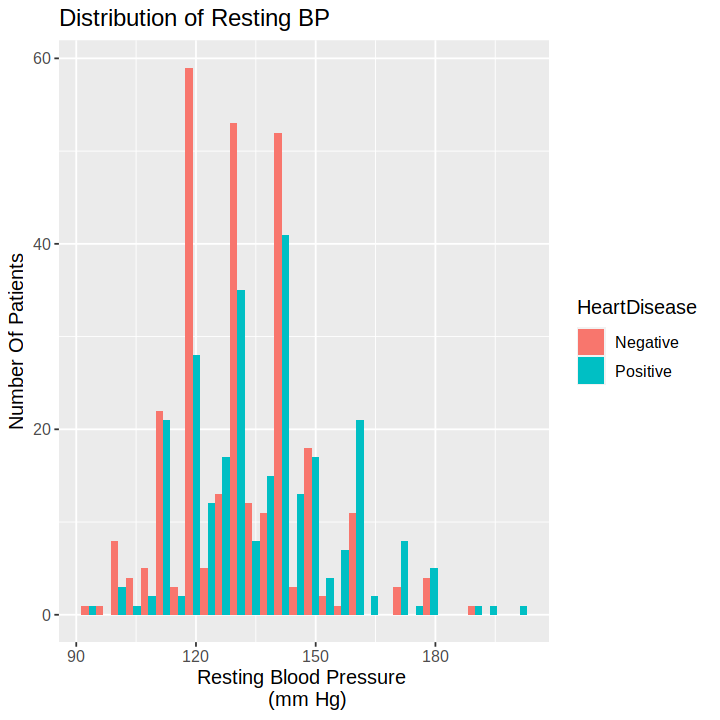

In [52]:
restbp_dist <- ggplot(training_data, aes(x = RestingBP, fill = HeartDisease)) + geom_histogram(position = "dodge") + 
         labs(x = "Resting Blood Pressure \n (mm Hg)", y = "Number Of Patients", colour = "Heart Disease") + ggtitle("Distribution of Resting BP") +
         theme(text = element_text(size=12)) 
restbp_dist

***figure 3***

The plot above shows a trend that at higher higher resting blood pressures then number of people with heart diseases tend to be more than the latter. Thus, elevated resting blood pressure could be a risk factor for heart disease.

#### Building the distribution of `HeartDisease` Patients and their `Age`

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


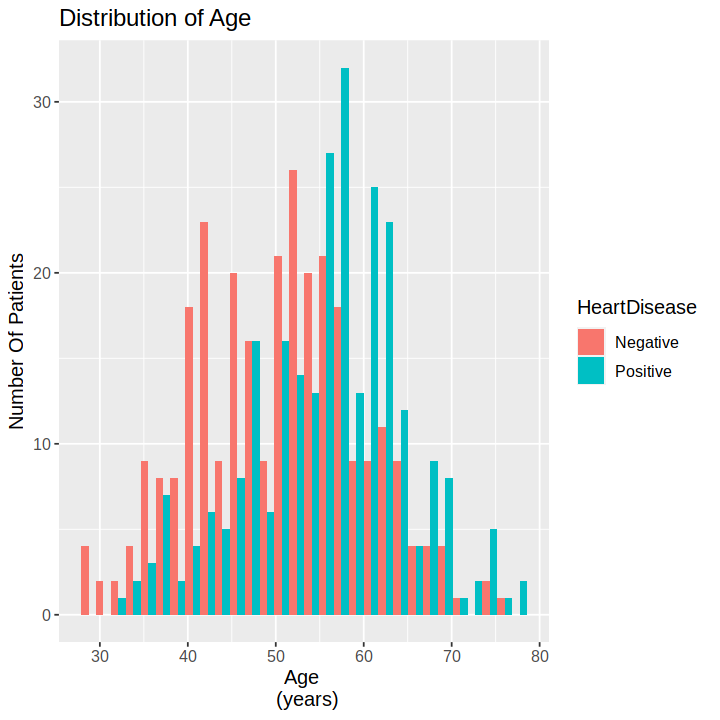

In [53]:
age_dist <- ggplot(training_data, aes(x = Age, fill = HeartDisease)) + geom_histogram(position = "dodge") + 
         labs(x = "Age \n (years)", y = "Number Of Patients", colour = "Heart Disease") + ggtitle("Distribution of Age") +
         theme(text = element_text(size=12)) 
age_dist

***figure 4***

From the plot, we can conclude that heart diseases tend to target older people. The number of people above the age of 55 years is consistently higher than the number of people without heart diseases.

#### Showing the distribution of `MaxHR` of `HeartDisease` patients

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


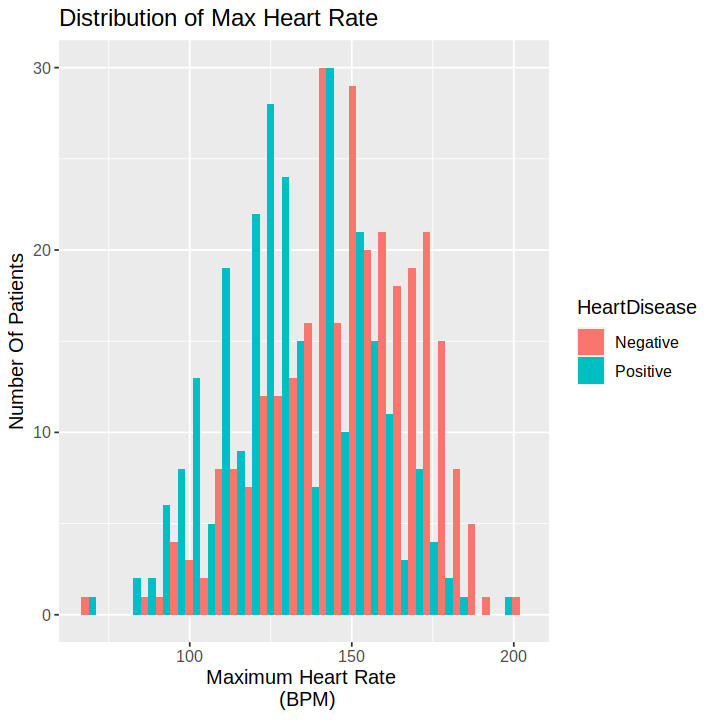

In [54]:
maxhr_dist <- ggplot(training_data, aes(x = MaxHR, fill = HeartDisease)) + geom_histogram(position = "dodge") + 
         labs(x = "Maximum Heart Rate \n (BPM)", y = "Number Of Patients", colour = "Heart Disease") + ggtitle("Distribution of Max Heart Rate") +
         theme(text = element_text(size=12)) 
maxhr_dist

***figure 5***

There is a clear yet surprising trend that we observe. The maximum heart rate for patients with heart disease is significantly lower than that for patients without heart diseases.

In [55]:
# characteristics of the training data
training_data |>
group_by(HeartDisease, Male) |>
summarize(Mean_Cholesterol = mean(Cholesterol, na.rm = TRUE), Mean_Age = mean(Age, na.rm = TRUE), Mean_RestingBP = mean(RestingBP, na.rn = TRUE),
          Mean_MaxHR = mean(MaxHR, na.rm = TRUE))

`summarise()` has grouped output by 'HeartDisease'. You can override using the
`.groups` argument.


HeartDisease Male Mean_Cholesterol Mean_Age Mean_RestingBP Mean_MaxHR
1 Negative     0    252.3048         51.26667 130.0095       148.3810  
2 Negative     1    233.0695         49.68984 131.0053       149.5561  
3 Positive     0    275.1765         55.82353 143.0294       141.5882  
4 Positive     1    245.6438         55.88412 135.9485       129.9957

***Table 1***

Through the table we can see that for both genders 0 (female) and 1 (male) patients with heart disease generally have higher cholesterol levels, age, and resting blood pressure with low max heart rate as compared to patients without heart diseases.

### Building The Model

We start by building the recipe for our model using `recipe()`. Centering and scaling of all the predictors is done through the functions `step_center` and `step_scale` functions.

While building the model for our data we use nearest_neighbor(), specify the engine as `kknn` and the mode to `classification`.

In [56]:
set.seed(1)
knn_recipe <- recipe(HeartDisease ~ . , data = training_data) |>
                step_center(all_predictors()) |>
                step_scale(all_predictors()) 
knn_recipe

knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
            set_engine("kknn") |>
            set_mode("classification")
knn_spec

Recipe

Inputs:

      role #variables
   outcome          1
 predictor          5

Operations:

Centering for all_predictors()
Scaling for all_predictors()

K-Nearest Neighbor Model Specification (classification)

Main Arguments:
  neighbors = tune()
  weight_func = rectangular

Computational engine: kknn 


We'll be performing  

In [ ]:
set.seed(1)

grid_vals <- tibble(neighbors = 1:200)

knn_vfold <- vfold_cv(training_data, v = 5, strata = HeartDisease)


knn_fit <- workflow() |>
            add_recipe(knn_recipe) |>
            add_model(knn_spec) |>
            tune_grid(resamples = knn_vfold, grid = grid_vals) |>
            collect_metrics() |>
            filter(.metric == "accuracy")
knn_fit

In [ ]:
options(repr.plot.width = 30, repr.plot.height = 5)
accuracy_versus_k <- ggplot(knn_fit, aes(x = neighbors, y = mean))+
      geom_point() +
      geom_line() +
      labs(x = "Neighbors", y = "Accuracy Estimate") + 
      theme(text = element_text(size = 10)) +
      scale_x_continuous(breaks = seq(1, 200, by = 1)) +  # adjusting the x-axis
      scale_y_continuous(limits = c(0.64, 0.74)) # adjusting the y-axis 
accuracy_versus_k
max_k <- knn_fit |> filter(mean==(max(mean))) |> slice_min(neighbors) |> pull(neighbors)
max_k

***figure 6***

In [ ]:
max_k_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = max_k) |>
            set_engine("kknn") |>
            set_mode("classification")
max_k_spec
max_k_fit <- workflow() |>
            add_recipe(knn_recipe) |>
            add_model(max_k_spec) |>
            fit(data = training_data)

test_predictions <- predict(max_k_fit , testing_data) |>
      bind_cols(testing_data)
test_predictions

In [ ]:
test_prediction_accuracy <- test_predictions |>
        metrics(truth = HeartDisease, estimate = .pred_class)    
test_prediction_accuracy
confusion_mat <- test_predictions |> 
      conf_mat(truth = HeartDisease, estimate = .pred_class)
confusion_mat

In [ ]:
precision <- 67 / (67 + 23)
precision
recall <- 67 / (67 + 22)
recall

### Reference List
- fedesoriano. (September 2021). Heart Failure Prediction Dataset. Retrieved [Date Retrieved] from https://www.kaggle.com/fedesoriano/heart-failure-prediction.
- Cholesterol levels - statpearls - NCBI bookshelf. (n.d.). https://www.ncbi.nlm.nih.gov/books/NBK542294/ 

**For the data set:**
Every dataset used can be found under the Index of heart disease datasets from UCI Machine Learning Repository on the following link: https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/

Creators:

    Hungarian Institute of Cardiology. Budapest: Andras Janosi, M.D.
    University Hospital, Zurich, Switzerland: William Steinbrunn, M.D.
    University Hospital, Basel, Switzerland: Matthias Pfisterer, M.D.
    V.A. Medical Center, Long Beach and Cleveland Clinic Foundation: Robert Detrano, M.D., Ph.D.

Donor:
David W. Aha (aha '@' ics.uci.edu) (714) 856-8779